In this issue of the Beacondigest, we first start off with exploring the dynamics of one of the largest staking protocol that is operating on PoS Ethereum - Lido. Specifically, we explore the Lido stETH contract to dive deeper into the mechanism using which staking deposits of 32 Eth works using the Lido protocol.

We begin by presenting our motivations for diving deeper into this data and our adopted methodology. We then present our finidings and move on to the recurring portion of our biweekly notebooks - assesing the health of the network. 

## Motivation

Lido is a liquid staking protocol for PoS Ethereum which has recently received a lot of attention in the space. According to data reports published in [Dune Analytics](https://duneanalytics.com/KIV/Lido-Deposits), the total amount of Eth staked using the Lido protocol is estimated to be - 594133 Eth. This makes Lido one of the largest staking entities in the PoS Ethereum protocol which controls roughly about 10% of the network.

Thus there is a lot of interest to dive deeper into the dynamics of the Lido protocol especially since they adopt a very unique approach to Eth staking by acting as a aggregator between users and a few stakers rather than taking custody of the funds and staking it themselves.

## Motivation

### Lido stETH Token

The Lido stETH token is an ERC20 token which is pegged 1:1 on the Eth which is staked user the Lido protocol. It is used to represent the initial deposits made by users as well as all the staking rewards they earn.

The ERC20 token used to mint these tokens can be found on Etherscan [here](https://etherscan.io/address/0xae7ab96520de3a18e5e111b5eaab095312d7fe84)

We felt that analyzing the smart contract and breaking it down was a good first step 

### Internal transactions

Internal transactions as shown on Etherscan, are essentially used to capture the interactions between different smart contracts. They are not real transactions which are recorded on the blockchain but are triggered by parent transactions which are. 

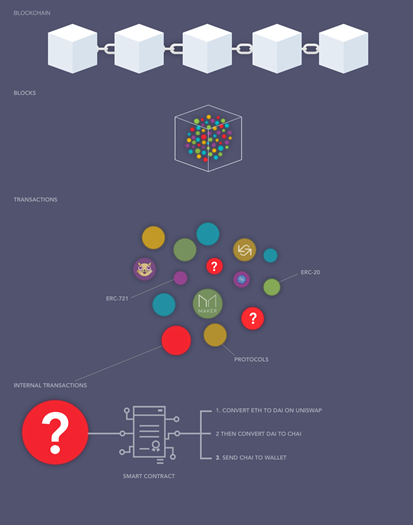

The above image (credits to [Blocknative](https://www.blocknative.com/)) details an internal transaction 

Thus diving deeper into the internal transactions of the stETH token contract would privovide us with novel insights on how different protocols or services interact with Lido

### Initial thoughts

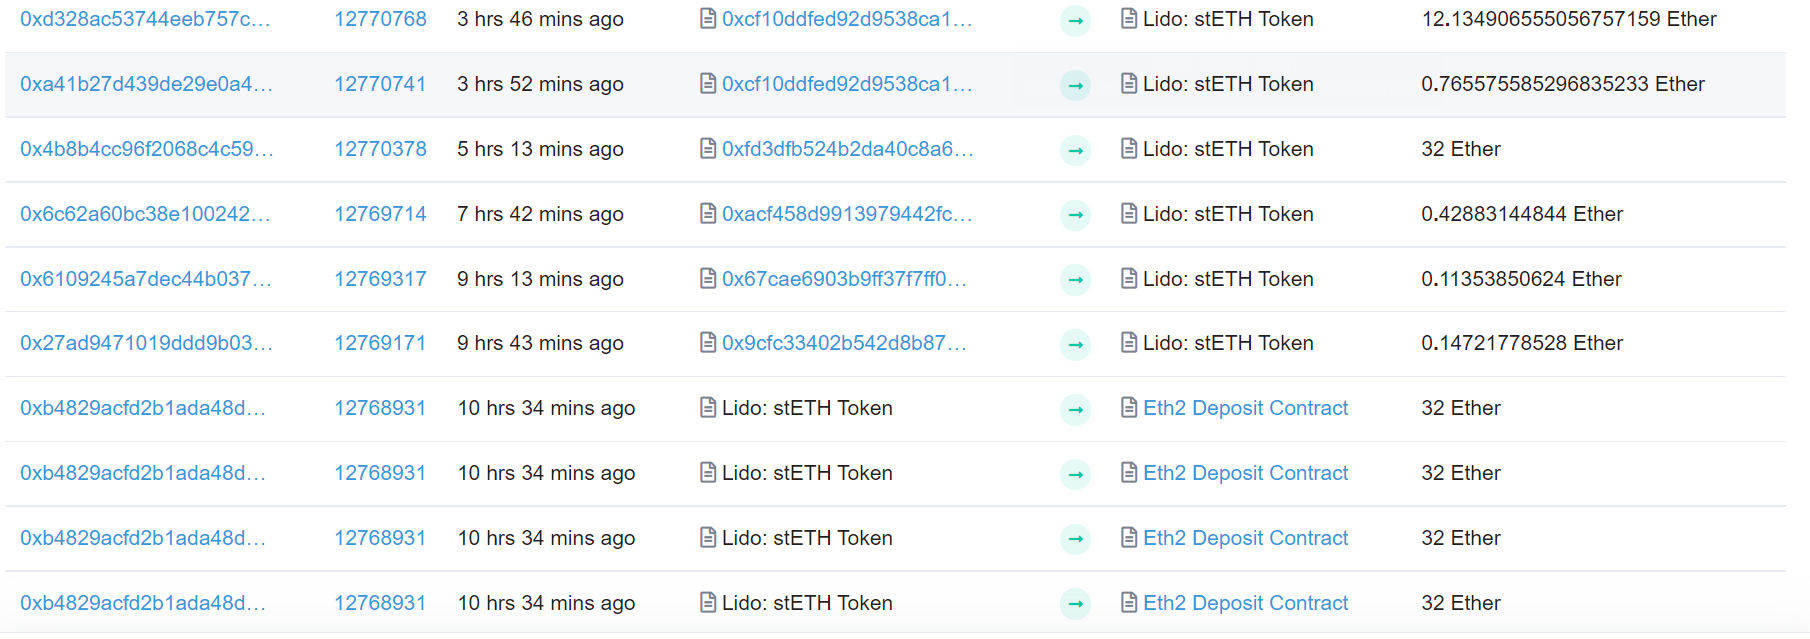

On first glance, we could say that there were roughly two types of internal transactions that were captured by the token contract - the first where some amount of Eth was deposited to the contract and the second where deposits of 32 Eth were made to the official Eth2 Deposit contract

Seeing how that this might be the right place to start the first step was to collect data pertaining to the internal transactions which we did using the csv files uploaded on Etherscan.

Since we also decided to use the web3 library for our analysis we also needed to establish an active connection with an Ethereum node hosted on Infura which is what we also did in the next few lines of code

In [1]:
from web3 import Web3
import json
import requests
import csv
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from time import *
import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.graph_objects as go
import math

In [42]:
with open('infura_url.txt', 'r') as file:
    infura_url = file.read()
        
web3 = Web3(Web3.HTTPProvider(infura_url))
web3.isConnected()

True

In [120]:
contract_address = web3.toChecksumAddress('0xae7ab96520de3a18e5e111b5eaab095312d7fe84')
abi = json.loads('[{"constant":true,"inputs":[],"name":"proxyType","outputs":[{"name":"proxyTypeId","type":"uint256"}],"payable":false,"stateMutability":"pure","type":"function"},{"constant":true,"inputs":[],"name":"isDepositable","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"implementation","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"appId","outputs":[{"name":"","type":"bytes32"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"kernel","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"inputs":[{"name":"_kernel","type":"address"},{"name":"_appId","type":"bytes32"},{"name":"_initializePayload","type":"bytes"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"},{"payable":true,"stateMutability":"payable","type":"fallback"},{"anonymous":false,"inputs":[{"indexed":false,"name":"sender","type":"address"},{"indexed":false,"name":"value","type":"uint256"}],"name":"ProxyDeposit","type":"event"}]')

In [3]:
df1 = pd.read_csv('import_file_1.csv', index_col=False, low_memory=False)
df2 = pd.read_csv('import_file_2.csv', index_col=False, low_memory=False)

frames = [df1, df2]
df = pd.concat(frames)

In many internal transactions, we  noticed that a single transaction made multiple deposits of 32 Eth to the Eth2 deposit contract thus we decided to prune the dataframe and remove all the entries with the same transaction hash for convinience sake 

In [4]:
df_pruned = df.drop_duplicates(subset = 'Txhash', keep = 'first')
print(len(df_pruned))

1856


As we see, there are 1856 unique internal transactions that we have to analyze 

In [43]:
deposit_transactions = df_pruned['TxTo'] == '0x00000000219ab540356cbb839cbe05303d7705fa'
stEth_token_transactions = df_pruned['TxTo'] == '0xae7ab96520de3a18e5e111b5eaab095312d7fe84' 
df_pruned_deposit_transactions = df_pruned[deposit_transactions]
df_pruned_stEth_token_transactions = df_pruned[stEth_token_transactions]
zero_value_transactions = df_pruned_stEth_token_transactions['Value_IN(ETH)'] == 0
df_pruned_zero_value_transactions = df_pruned_stEth_token_transactions[zero_value_transactions]
print(len(df_pruned_deposit_transactions))
print(len(df_pruned_stEth_token_transactions))
#print(len(df_pruned_zero_value_transactions))

195
1661


Out of these 1856 transactions, there are 195 deposit transactions.

One point to note here is that this is the pruned database which we are analysing meaning that there is a lot more than 195 deposits of 32Eth made to the Eth2 Deposit Contract, since in many cases a single transaction triggers multiple deposits activating multiple validators.

In [284]:
df_pruned_deposit_transactions.to_csv('lido_deposits.csv', index = False)
df_pruned_stEth_token_transactions.to_csv('lido_stEth_token_transactions.csv', index = False)

In [249]:
txn_hash_deposit_transactions = df_pruned_deposit_transactions.iloc[:, 0]
data_list_eth2_deposits = []
txn_hash_stEth_token_transactions = df_pruned_stEth_token_transactions.iloc[:, 0]
data_list_stEth_token_transactions = []

To collect additional data on the parent transaction, we used the web3py library's `get_transaction` method

In [250]:
for i in txn_hash_deposit_transactions:
    #print(i)
    data_list_eth2_deposits.append(web3.eth.get_transaction(i))

In [251]:
for i in txn_hash_stEth_token_transactions:
    #print(i)
    data_list_stEth_token_transactions.append(web3.eth.get_transaction(i))

In [285]:
df_gas_deposits = pd.DataFrame(data_list_eth2_deposits)

df_gas_stEth_toekn_transactions = pd.DataFrame(data_list_stEth_token_transactions)


# print(df_deposit_transactions)
# print(df_stEth_token_transactions)

In [286]:
df_gas_deposits.to_csv('lido_deposits_with_gas.csv', index = False)
df_gas_stEth_toekn_transactions.to_csv('lido_stEth_token_transactions_with_gas.csv', index = False)

Once the final dataframe was read for us to work with, the next step was to gain some novel insights into the process flow leading to deposit transactions made using the Lido protocol by seeing the unique From and True address pairs for these transactions. 

This would give us an idea on who triggers these deposits and would demistify the architecture set in place for making these deposits.

In [7]:
df_deposit_transactions_pairs = df_pruned_deposit_transactions.groupby(['ParentTxFrom','ParentTxTo', 'TxTo', 'From']).size().reset_index().rename(columns={0:'count'})
df_deposit_transactions_pairs.sort_values(["count"], ascending=False)

,ParentTxFrom,ParentTxTo,TxTo,From,count
2,0x6352f8c749954c9df198cf72976e48994a77cce2,0x1ee5c83c4b43aaed21613d5cc7835d36078ce03f,0x00000000219ab540356cbb839cbe05303d7705fa,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,72
5,0xa76a7d0d06754e4fc4941519d1f9d56fd9f8d53b,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,0x00000000219ab540356cbb839cbe05303d7705fa,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,53
0,0x00444797ba158a7bdb8302e72da98dcbccef0fbc,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,0x00000000219ab540356cbb839cbe05303d7705fa,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,36
1,0x073adf97f6de257d76e67f7c2fe57ac9843cca25,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,0x00000000219ab540356cbb839cbe05303d7705fa,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,25
6,0xc8381ca290c198f5ab739a1841ce8aedb0b330d5,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,0x00000000219ab540356cbb839cbe05303d7705fa,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,5
3,0x6e34e47df7026e0ace9457f930f1cfada6f547c4,0x1ee5c83c4b43aaed21613d5cc7835d36078ce03f,0x00000000219ab540356cbb839cbe05303d7705fa,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,3
4,0x99b2c5d50086b02f83e791633c5660fbb8344653,0x1ee5c83c4b43aaed21613d5cc7835d36078ce03f,0x00000000219ab540356cbb839cbe05303d7705fa,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,1


## Inferences

Based on our finidings from the previous section, we were able to hypothise a rough structural architecture diagram on how deposits work with Lido.

After taking a look at the results of our analysis, we can see that there exists 7 unique 'From' and 'To' address pairs which when they transact, triggers a deposit of 32 Eth to be made to the Eth2 deposit contract.

What is interesting here is that there are 2 distinct 'To' addresses - the first one being the StETH token contract and the other a contract that goes by the name 'Vyper_contract'

#### stETH Token contract 

On reading the contract [documentation](https://github.com/lidofinance/docs/blob/49db2ad064e7d759931e3a2e633a7a3a46e8330c/docs/contracts/lido.md), we identify that the method of interest to us is `depositBufferedEther()` which when called makes a deposit of 32 Eth to the official DepositContract. The Eth deposited is the Eth which is temorarily buffered in the contract. 

Thus, through this first channel we have 4 "depositors" (possibly Lido employees) with distinct wallet addresses invoking the `depositBufferedEther()` by sending a transaction of 0 Eth to the stETH token contract.

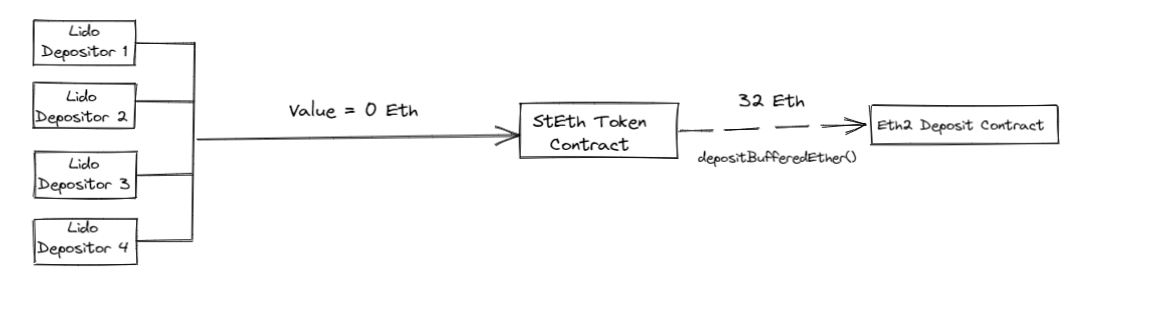

#### Vyper_contract

What is very interesting about this contract is the fact that it has a reference to KeeperDAO. A transaction to this contract also triggers a deposit through the same `depositBufferedEther()` function in the stETH contract since it has a reference to the same. 

The contract uses an assertion statement with the `isKeeper(address keeper) → bool` method to ensure that the person sending the message is a keeper (participants who execute available jobs in exchange for a reward in the Keep3r network).

Thus the way this is set up is, a keeper can directly use their Eth to activate new validators in the beacon chain rather than going through the regular endpoint that "normal" users would have to go through.

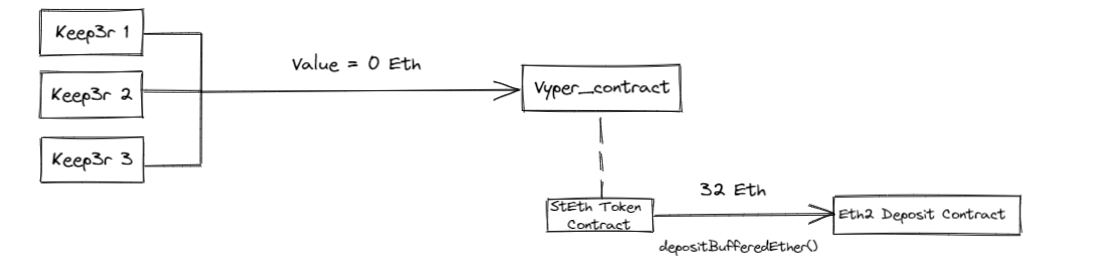

In addition to our above analysis, we also look closer into the gas fees that was spent for making these deposits 

High transaction fees is an indicator of the network being busier with more people making transactions such as DEX trades or Asset deposits. 

In [44]:
df_lido_deposits_with_gas = pd.read_csv("lido_deposits_with_gas.csv") 
#df_lido_deposits_with_gas

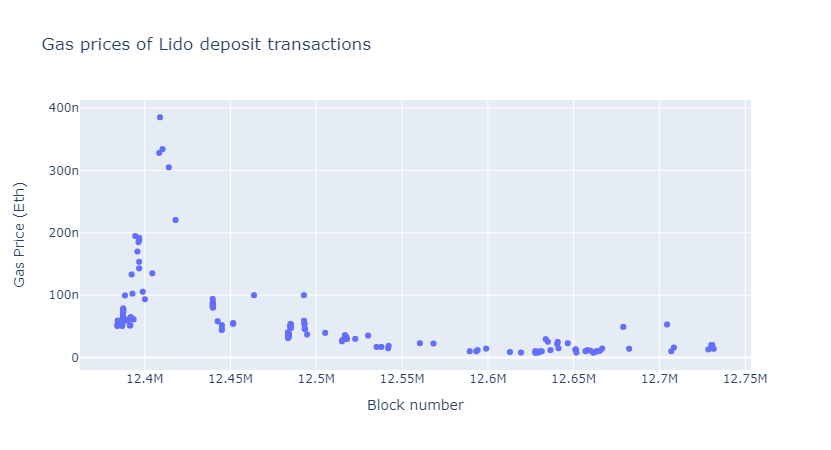

In [36]:
# x = df_lido_deposits_with_gas["blockNumber"]
y = df_lido_deposits_with_gas["gasPrice"]
lst = []
for i in y:
    #lst.append(int(i)/(10**8))
    lst.append(Web3.fromWei(int(i), 'ether'))
fig = px.scatter(x = df_lido_deposits_with_gas["blockNumber"] ,y = lst, title = "Gas prices of Lido deposit transactions")
fig.update_layout(xaxis_title = "Block number", yaxis_title = "Gas Price (Eth)")
fig.show()

Through the above graph we thus get more insights into roughly how much Lido spent on gas fees needed to make these deoposits and how they were distributed over time.

The trend that we notice is that the transaction fees really peaked soon after Lido first started activating validators possibly due to the network being congested by everyone depositing their Eth to the beacon chain soon after its launch. 

However, the transaction fees gradually decreased to a value far lesser than the maximum value